In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch import optim
from torch import mps
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, minmax_scale, power_transform, scale
# from tqdm import tqdm
import os
import ast
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, StochasticWeightAveraging
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import torchmetrics.functional as tmf

from helpers.iterative import IT_DATAMODULE
from models.iterative import CNN_1D_LSTM
from pytorch_ranger import Ranger

# Set global seed for reproducibility in numpy, torch, scikit-learn

# torch.manual_seed(42)
# torch.mps.manual_seed(42)
# torch.backends.mps.deterministic = True
# torch.cuda.manual_seed(42)
# torch.backends.cudnn.deterministic = True
# np.random.seed(42)
%autosave 0

Autosave disabled


In [2]:
def inference(mode="test"):

    ROOTDIR = "./logs/hp_opt_it_price_monthly_1mo/"
    with open("./DATA/Tickers/month_tickers_clean.txt", "r") as f:
        tickers = f.read().strip().split("\n")

    if torch.cuda.is_available():
        DEVICE = "cuda"
        torch.set_float32_matmul_precision("medium")
    elif torch.backends.mps.is_available():
        DEVICE = "mps"
    else:
        DEVICE = "cpu"

    preds = []
    trues = []
    param_list = []
    stocks = []
    losses = []
    mses = []
    maes = []
    mapes = []

    for run in range(409):
        stocks.append(tickers[int(run)])
        with open(os.path.join(ROOTDIR, str(run), "best_trial.txt")) as f:
            text = f.readlines()
            best_trial = text[0].strip()
            params = ast.literal_eval(text[2].strip().replace("Params: ", ""))
            #param_list.append(params)
            loss = float(text[1].strip().replace("Loss: ", ""))
            losses.append(loss)
        with open(os.path.join(ROOTDIR, str(run), best_trial, "best_checkpoint.txt")) as f:
            text = f.readlines()
            best_checkpoint = text[1].strip().replace("Best Checkpoint: ", "")
            ckpt = torch.load(best_checkpoint, map_location=DEVICE)
            params["epochs"] = ckpt["epoch"]
            param_list.append(params)

        print(f"Working on ticker {run} of {len(tickers)}") if run % 100 == 0 else None

        if mode == "test":

            data = IT_DATAMODULE(
                batch_size=params["batch_size"],
                lookback=params["lookback"],
                pred_horizon=1,
                multistep=False,
                data_type="monthly",
                ticker_idx=run,
                train_workers=0,
                overwrite_cache=False,
                pred_target="price",
            )

            # Global model hyperparameters and constants
            data.prepare_data()
            data.setup()

            # data = IT_DATAMODULE(
            #     batch_size=16,
            #     lookback=24,
            #     pred_horizon=1,
            #     multistep=False,
            #     data_type="monthly",
            #     ticker_idx=run,
            #     train_workers=0,
            #     overwrite_cache=False,
            #     pred_target="price",
            # )

            # data.prepare_data()
            # data.setup()

            # model = CNN_1D_LSTM(
            #     n_features=data.X_train_tensor.shape[-1],
            #     lookback=24,
            #     epochs=150,
            #     batches_p_epoch=int(np.ceil(len(data.X_train_tensor) / 16)),
            #     cnn_layers=2,
            #     conv_factor=0.5,
            #     lstm_layers=2,
            #     lstm_nodes=64,
            #     fc_layers=1,
            #     fc_nodes=64,
            #     dropout=0.3,
            #     bidirectional=False,
            #     lr=0.001,
            #     optimizer=Ranger,
            #     )
            
            # X = torch.cat([data.X_train_tensor, data.X_val_tensor], dim=0)
            # y = torch.cat([data.y_train_tensor, data.y_val_tensor.unsqueeze(1)], dim=0)
            # train_ds = TensorDataset(X, y)
            # train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0)
            
            # trainer = pl.Trainer(
            #     accelerator=DEVICE,
            #     logger=False,
            #     enable_checkpointing=False,
            #     enable_progress_bar=False,
            #     enable_model_summary=False,
            #     max_epochs=150,
            # )

            # trainer.fit(model, train_dl)
            model = CNN_1D_LSTM.load_from_checkpoint(best_checkpoint, optimizer=Ranger)
        else:

            data = IT_DATAMODULE(
                batch_size=params["batch_size"],
                lookback=params["lookback"],
                pred_horizon=1,
                multistep=False,
                data_type="monthly",
                ticker_idx=run,
                train_workers=0,
                overwrite_cache=False,
                pred_target="price",
            )

            # Global model hyperparameters and constants
            data.prepare_data()
            data.setup()

            model = CNN_1D_LSTM.load_from_checkpoint(best_checkpoint, optimizer=Ranger)

        model.eval()
        with torch.inference_mode():
            if mode == "test":
                model.to(DEVICE)
                y_pred = model(data.X_test_tensor.to(DEVICE)).squeeze(1)
                maes.append(tmf.mean_absolute_error(y_pred, data.y_test_tensor.to(DEVICE)).item())
                mses.append(tmf.mean_squared_error(y_pred, data.y_test_tensor.to(DEVICE)).item())
                mapes.append(tmf.mean_absolute_percentage_error(y_pred, data.y_test_tensor.to(DEVICE)).item())
                
                preds.append(y_pred.cpu().detach().numpy().item())
                trues.append(data.y_test_tensor.cpu().detach().numpy().item())
            else:
                model.to(DEVICE)
                y_pred = model(data.X_val_tensor.to(DEVICE)).squeeze(1)
                maes.append(tmf.mean_absolute_error(y_pred, data.y_val_tensor.to(DEVICE)).item())
                mses.append(tmf.mean_squared_error(y_pred, data.y_val_tensor.to(DEVICE)).item())
                mapes.append(tmf.mean_absolute_percentage_error(y_pred, data.y_val_tensor.to(DEVICE)).item())
                
                preds.append(y_pred.cpu().detach().numpy().item())
                trues.append(data.y_val_tensor.cpu().detach().numpy().item())

    return pd.DataFrame({"ticker": tickers, "preds": preds, "trues": trues, "loss": losses, "mae": maes, "mse": mses, "mape": mapes, "params": param_list})

In [3]:
val = inference(mode="val")

Working on ticker 0 of 409
Working on ticker 100 of 409
Working on ticker 200 of 409
Working on ticker 300 of 409
Working on ticker 400 of 409


In [4]:
print(f"Val MAPE: {mean_absolute_percentage_error(val['preds'].values, val['trues'].values):.2%}")
print(f"Val MAE: {mean_absolute_error(val['preds'].values, val['trues'].values):.2f}")
print(f"Val MSE: {mean_squared_error(val['preds'].values, val['trues'].values):.2f}")
print(f"Val RMSE: {mean_squared_error(val['preds'].values, val['trues'].values, squared=False):.2f}")

Val MAPE: 3.08%
Val MAE: 0.74
Val MSE: 51.06
Val RMSE: 7.15


In [5]:
test = inference(mode="test")

Working on ticker 0 of 409
Working on ticker 100 of 409
Working on ticker 200 of 409
Working on ticker 300 of 409
Working on ticker 400 of 409


In [6]:
print(f"Test MAPE: {mean_absolute_percentage_error(test['preds'].values, test['trues'].values):.2%}")
print(f"Test MAE: {mean_absolute_error(test['preds'].values, test['trues'].values):.2f}")
print(f"Test MSE: {mean_squared_error(test['preds'].values, test['trues'].values):.2f}")
print(f"Test RMSE: {mean_squared_error(test['preds'].values, test['trues'].values, squared=False):.2f}")

Test MAPE: 11.97%
Test MAE: 2.62
Test MSE: 284.40
Test RMSE: 16.86


## Overview of Parameter Frequencies

In [7]:
val["params"].str.get("bidirectional").value_counts()

False    334
True      75
Name: params, dtype: int64

<Axes: >

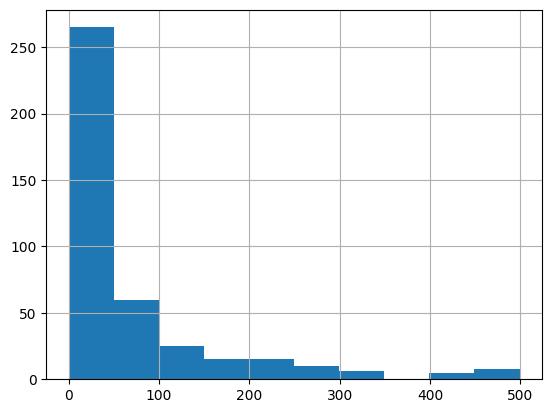

In [8]:
val["params"].str.get("epochs").hist()

<Axes: >

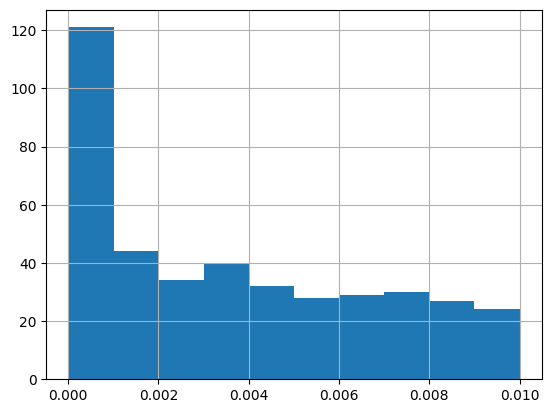

In [9]:
val["params"].str.get("lr").hist()

<Axes: >

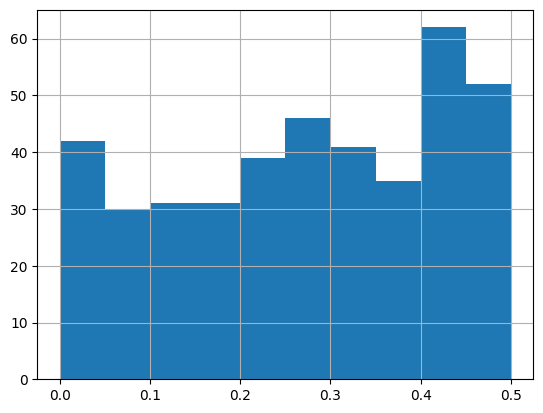

In [10]:
val["params"].str.get("dropout").hist()

In [11]:
val["params"].str.get("batch_size").value_counts()

16    258
32    115
64     36
Name: params, dtype: int64

In [12]:
val["params"].str.get("lookback").value_counts()

1     102
24     98
12     87
6      65
3      57
Name: params, dtype: int64

In [13]:
val["params"].str.get("lstm_layers").value_counts()

1    231
2    100
3     78
Name: params, dtype: int64

In [14]:
val["params"].str.get("lstm_nodes").value_counts()

256    132
128    101
32      91
64      85
Name: params, dtype: int64

In [15]:
val["params"].str.get("fc_layers").value_counts()

2    175
1    119
3    115
Name: params, dtype: int64

In [16]:
val["params"].str.get("fc_nodes").value_counts()

256    173
128     99
64      78
32      59
Name: params, dtype: int64

In [17]:
val["params"].str.get("cnn_layers").value_counts()

1    185
2    148
3     76
Name: params, dtype: int64

<Axes: >

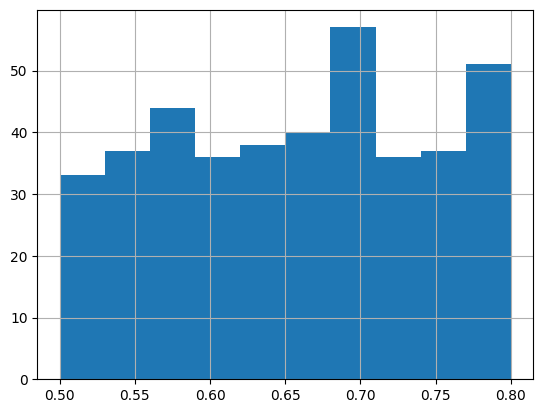

In [18]:
val["params"].str.get("conv_factor").hist()

## Portfolio Construction

In [19]:
# Make function and then look if batch 1 alone can do the shit
def prep_dfs(val, test):
    fin_df = pd.read_parquet("./DATA/Monthly/Processed/month_data_fin_tec.parquet")
    val_df = val.copy()
    test_df = test.copy()

    val_df["act_return"] = val_df["ticker"].apply(lambda x: fin_df[f"{x}_CP"].pct_change().iloc[-2]*100)
    val_df["pred_return"] = val_df.apply(lambda row: ((row["preds"]) - (fin_df[f"{row['ticker']}_CP"].iloc[-3])) / (fin_df[f"{row['ticker']}_CP"].iloc[-3])*100, axis=1)

    test_df["act_return"] = test_df["ticker"].apply(lambda x: fin_df[f"{x}_CP"].pct_change().iloc[-1]*100)
    test_df["pred_return"] = test_df.apply(lambda row: ((row["preds"]) - (fin_df[f"{row['ticker']}_CP"].iloc[-2])) / (fin_df[f"{row['ticker']}_CP"].iloc[-2])*100, axis=1)

    return val_df, test_df

In [20]:
val, test = prep_dfs(val, test)

In [21]:
val.groupby(val["params"].str.get("fc_nodes")).mean().sort_values(by="mse", ascending=False)

/var/folders/d1/l1bm7lrx6l91ph6t43zbct0c0000gn/T/ipykernel_66652/2828627695.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  val.groupby(val["params"].str.get("fc_nodes")).mean().sort_values(by="mse", ascending=False)


,preds,trues,loss,mae,mse,mape,act_return,pred_return
params,,,,,,,,
256,45.133582,46.246931,179.763983,1.154826,110.852031,0.012787,0.388552,-0.399509
128,28.587303,29.156010,17.626441,0.603227,15.180012,0.019263,-0.705637,-2.490512
64,24.604663,24.795192,2.165361,0.295653,1.615770,0.015379,-0.741429,-1.272592
32,19.233435,19.541441,2.798433,0.337967,1.327296,0.012638,-1.682410,-2.608966


In [22]:
val.groupby(val["params"].str.get("lookback")).mean().sort_values(by="act_return", ascending=False)

/var/folders/d1/l1bm7lrx6l91ph6t43zbct0c0000gn/T/ipykernel_66652/4274595591.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  val.groupby(val["params"].str.get("lookback")).mean().sort_values(by="act_return", ascending=False)


,preds,trues,loss,mae,mse,mape,act_return,pred_return
params,,,,,,,,
24,30.757536,31.079592,6.546286,0.392088,3.838159,0.023284,0.950250,-0.520088
12,64.883117,66.790162,351.823291,1.976794,216.638431,0.013309,0.488220,-0.707682
3,22.472709,22.591579,0.547949,0.164255,0.205958,0.012080,-0.415720,-0.851496
6,18.569811,18.586077,0.186350,0.054763,0.029130,0.002991,-0.525575,-0.643968
1,24.952326,25.703677,18.477297,0.776251,16.149478,0.017075,-2.328170,-3.587615


In [23]:
val_portfolio = val.loc[
    (val["params"].str.get("lookback") == 24) 
    & (val["pred_return"] > 0) 
    & (val["params"].str.get("fc_nodes") <= 64)]\
    .sort_values(by="pred_return", ascending=False)
#val_portfolio = val.loc[(val["params"].str.get("lstm_nodes") == 32) & (val["params"].str.get("fc_nodes") == 64) & (val["pred_return"] > 0)].sort_values(by="pred_return", ascending=False).head(20)
# val_portfolio = val.sort_values(by="pred_return", ascending=False).head(20)
# val_portfolio = val.loc[(val["mape"] < 0.005)].sort_values(by="pred_return", ascending=False).head(10)
val_portfolio.to_csv("./results/IT/val_portfolio.csv", index=False)
val_portfolio

,ticker,preds,trues,loss,mae,mse,mape,params,act_return,pred_return
175,BLU,20.267626,19.590000,39.636032,0.677626,4.591765e-01,3.459039e-02,"{'batch_size': 16, 'lookback': 24, 'epochs': 0...",101.750772,108.729411
208,DBG,0.509553,0.510000,0.000001,0.000447,2.001600e-07,8.772401e-04,"{'batch_size': 16, 'lookback': 24, 'epochs': 1...",15.909091,15.807409
128,BHC,11.834883,9.970000,20.697920,1.864882,3.477787e+00,1.870494e-01,"{'batch_size': 64, 'lookback': 24, 'epochs': 1...",-8.949772,8.081121
15,RCH,39.985252,40.740002,1.521083,0.754749,5.696465e-01,1.852600e-02,"{'batch_size': 16, 'lookback': 24, 'epochs': 4...",9.105517,7.084232
294,PPTA,6.431440,6.450000,0.000383,0.018559,3.444534e-04,2.877435e-03,"{'batch_size': 16, 'lookback': 24, 'epochs': 1...",7.142857,6.834557
23,TCN,10.859990,10.860000,0.000036,0.000010,9.094947e-11,8.781532e-07,"{'batch_size': 64, 'lookback': 24, 'epochs': 4...",3.625954,3.625860
53,EQB,60.130161,60.099998,0.007198,0.030163,9.097952e-04,5.018770e-04,"{'batch_size': 16, 'lookback': 24, 'epochs': 1...",3.087479,3.139213
162,WCP,10.677123,10.680000,0.000016,0.002877,8.278484e-06,2.694041e-04,"{'batch_size': 16, 'lookback': 24, 'epochs': 6...",2.200957,2.173427
7,EFR,7.698582,7.700000,0.001508,0.001418,2.011046e-06,1.841706e-04,"{'batch_size': 16, 'lookback': 24, 'epochs': 2...",2.122016,2.103206
32,RNW,12.658909,12.650000,0.000133,0.008909,7.937429e-05,7.042866e-04,"{'batch_size': 16, 'lookback': 24, 'epochs': 1...",1.688103,1.759717


In [24]:
val_portfolio["act_return"].mean()

10.146367043374553

In [33]:
# test_portfolio = test.loc[(test["params"].str.get("lstm_nodes") <= 256) & (test["pred_return"] > 0) & (test["params"].str.get("fc_nodes") <= 64)].sort_values(by="pred_return", ascending=False).head(10)
test_portfolio = test.loc[
    (test["params"].str.get("lookback") == 24) 
    & (test["pred_return"] > 0) 
    & (test["params"].str.get("fc_nodes") <=64)] \
    .sort_values(by="pred_return", ascending=False)
# test_portfolio = test.loc[(test["params"].str.get("lstm_nodes") == 32) & (test["params"].str.get("fc_nodes") == 64) & (test["pred_return"] > 0)].sort_values(by="pred_return", ascending=False).head(20)
# test_portfolio = test.sort_values(by="pred_return", ascending=False).head(20)
# test_portfolio = test.loc[(val["mape"] < 0.005)].sort_values(by="pred_return", ascending=False).head(20)
test_portfolio.to_csv("./results/IT/test_portfolio.csv", index=False)
test_portfolio

,ticker,preds,trues,loss,mae,mse,mape,params,act_return,pred_return
128,BHC,11.834883,11.140000,20.697920,0.694882,0.482862,0.062377,"{'batch_size': 64, 'lookback': 24, 'epochs': 1...",11.735206,18.704942
175,BLU,20.318451,19.840000,39.636032,0.478451,0.228915,0.024115,"{'batch_size': 16, 'lookback': 24, 'epochs': 0...",1.276161,3.718484
303,HRX,13.171913,13.590000,0.004020,0.418087,0.174797,0.030764,"{'batch_size': 16, 'lookback': 24, 'epochs': 7...",5.512422,2.266406
162,WCP,10.903764,9.290000,0.000016,1.613764,2.604234,0.173710,"{'batch_size': 16, 'lookback': 24, 'epochs': 6...",-13.014981,2.095166
158,SNC,31.306265,31.700001,0.012965,0.393736,0.155028,0.012421,"{'batch_size': 16, 'lookback': 24, 'epochs': 2...",1.602564,0.340593
253,REG,0.790874,0.760000,0.005116,0.030874,0.000953,0.040623,"{'batch_size': 16, 'lookback': 24, 'epochs': 1...",-3.797468,0.110573
23,TCN,10.867355,10.910000,0.000036,0.042645,0.001819,0.003909,"{'batch_size': 64, 'lookback': 24, 'epochs': 4...",0.460405,0.067729
32,RNW,12.657658,12.610000,0.000133,0.047658,0.002271,0.003779,"{'batch_size': 16, 'lookback': 24, 'epochs': 1...",-0.316206,0.060535
109,SRU-U,26.181370,25.340000,0.000003,0.841370,0.707903,0.033203,"{'batch_size': 16, 'lookback': 24, 'epochs': 3...",-3.208556,0.005232


In [34]:
test_portfolio["act_return"].mean()

0.027727470202438376

## Market Benchmark

## Prophet Benchmark

In [ ]:
from prophet import Prophet
from prophet.plot import plot_plotly
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tqdm.auto import trange

In [ ]:
def prophet_inference(mode="test"):

    with open("./DATA/Tickers/month_tickers_clean.txt", "r") as f:
        tickers = f.read().strip().split("\n")

    fin = pd.read_parquet("./DATA/Monthly/Processed/month_data_fin_tec.parquet")
    macro = pd.read_parquet("./DATA/Monthly/Processed/month_data_macro_USCA.parquet")

    maes = []
    mses = []
    mapes = []
    preds = []
    trues = []

    for idx in trange(409):
        ticker = tickers[idx]

        data = pd.concat([fin.filter(regex=f"^{ticker}_").copy(), macro.copy()], axis=1)
        data = data[data[f"{ticker}_CP"] != 0]
        data = data.loc[:, data.var() != 0]
        data = data.reset_index().rename(columns={"index": "ds", f"{ticker}_CP": "y"})
        df = data.copy()

        m = Prophet(
            growth="linear",
            changepoint_prior_scale=0.5,
            seasonality_prior_scale=0.01,
            changepoint_range=0.9,
            seasonality_mode="additive",
        )
        for col in df.columns:
            if col not in ["y", "ds"]:
                df[col] = df[col].shift(1)
                m.add_regressor(col)

        df = df.dropna()
        df["day_of_week"] = df["ds"].dt.day_of_week
        df["day_of_month"] = df["ds"].dt.day
        df["day_of_year"] = df["ds"].dt.dayofyear
        df["week_of_year"] = df["ds"].dt.isocalendar().week
        df["month_of_year"] = df["ds"].dt.month
        df["quarter_of_year"] = df["ds"].dt.quarter

        if mode == "test":

            train = df.iloc[:-1]
            m.fit(train)

            future = m.make_future_dataframe(periods=1, freq="M")
            future = pd.concat([future, df.drop(columns=["ds", "y"]).reset_index(drop=True)], axis=1)

            forecast = m.predict(future)
            val_true = np.array([df.iloc[-1]["y"]])
            trues.append(val_true.item())

        else:
            train = df.iloc[:-2]
            m.fit(train)

            future = m.make_future_dataframe(periods=1, freq="M")
            future = pd.concat([future, df.iloc[:-1].drop(columns=["ds", "y"]).reset_index(drop=True)], axis=1)

            forecast = m.predict(future)
            val_true = np.array([df.iloc[-2]["y"]])
            trues.append(val_true.item())
            
        val_pred = np.array([forecast.iloc[-1]["yhat"]])
        preds.append(val_pred.item())

        maes.append(mean_absolute_error(val_true, val_pred))
        mses.append(mean_squared_error(val_true, val_pred))
        mapes.append(mean_absolute_percentage_error(val_true, val_pred))

    return pd.DataFrame({"ticker": tickers, "preds": preds, "trues": trues, "mae": maes, "mse": mses, "mape": mapes})

In [ ]:
proph_val = prophet_inference(mode="val")

In [ ]:
print(f"Val MAPE: {mean_absolute_percentage_error(proph_val['preds'].values, proph_val['trues'].values):.2%}")
print(f"Val MAE: {mean_absolute_error(proph_val['preds'].values, proph_val['trues'].values):.2f}")
print(f"Val MSE: {mean_squared_error(proph_val['preds'].values, proph_val['trues'].values):.2f}")
print(f"Val RMSE: {mean_squared_error(proph_val['preds'].values, proph_val['trues'].values, squared=False):.2f}")

In [ ]:
proph_test = prophet_inference(mode="test")

In [ ]:
print(f"Test MAPE: {mean_absolute_percentage_error(proph_test['preds'].values, proph_test['trues'].values):.2%}")
print(f"Test MAE: {mean_absolute_error(proph_test['preds'].values, proph_test['trues'].values):.2f}")
print(f"Test MSE: {mean_squared_error(proph_test['preds'].values, proph_test['trues'].values):.2f}")
print(f"Test RMSE: {mean_squared_error(proph_test['preds'].values, proph_test['trues'].values, squared=False):.2f}")

In [ ]:
# Make function and then look if batch 1 alone can do the shit
def prep_dfs(val, test):
    fin_df = pd.read_parquet("./DATA/Monthly/Processed/month_data_fin_tec.parquet")
    val_df = val.copy()
    test_df = test.copy()

    val_df["act_return"] = val_df["ticker"].apply(lambda x: fin_df[f"{x}_CP"].pct_change().iloc[-2]*100)
    val_df["pred_return"] = val_df.apply(lambda row: ((row["preds"]) - (fin_df[f"{row['ticker']}_CP"].iloc[-3])) / (fin_df[f"{row['ticker']}_CP"].iloc[-3])*100, axis=1)

    test_df["act_return"] = test_df["ticker"].apply(lambda x: fin_df[f"{x}_CP"].pct_change().iloc[-1]*100)
    test_df["pred_return"] = test_df.apply(lambda row: ((row["preds"]) - (fin_df[f"{row['ticker']}_CP"].iloc[-2])) / (fin_df[f"{row['ticker']}_CP"].iloc[-2])*100, axis=1)

    return val_df, test_df

In [ ]:
proph_val, proph_test = prep_dfs(proph_val, proph_test)

In [ ]:
proph_val

In [ ]:
proph_test

In [ ]:
proph_val_portfolio = proph_val.loc[(proph_val["mape"] < 0.005)].sort_values(by="pred_return", ascending=False).head(10)
proph_val_portfolio.to_csv("./results/IT/prophet_val_portfolio.csv", index=False)
proph_val_portfolio

In [ ]:
proph_val_portfolio["act_return"].sum()

In [ ]:
proph_test_portfolio = proph_test.loc[(proph_val["mape"] < 0.005)].sort_values(by="pred_return", ascending=False).head(10)
proph_test_portfolio.to_csv("./results/IT/prophet_test_portfolio.csv", index=False)
proph_test_portfolio

In [ ]:
proph_test_portfolio["act_return"].sum()

## Market Returns

In [27]:
((2800.56 - 2835.93) / 2835.93)*100 # MSCI World test period

-1.2472099099766176

In [28]:
((19572.2 - 20636.5) / 20636.5)*100 # TSX S&P 500 Composite test period

-5.157366801540955

In [29]:
((2835.93 - 2791.44) / 22791.44)*100 # MSCI World val period

0.1952048663884326

In [30]:
((20636.50 - 20099.90) / 20099.90)*100 # TSX S&P 500 Composite val period

2.6696650232090633